**Data Set Generation:**

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import radians, cos, sin, asin, sqrt
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of IoT devices and tasks
total_tasks = 5000

# Base timestamp
base_time = datetime(2025, 1, 1, 0, 0, 0)

# Dhaka base GPS coordinates (reference point for distance)
base_lat = 23.8103
base_lon = 90.4125

# Define 10 different area centers in Dhaka
area_centers = [
    # Area 1: Jatrabari
    (23.7460, 90.4345),
    # Area 2: Dhanmondi
    (23.7465, 90.3716),
    # Area 3: Gulshan
    (23.7800, 90.4167),
    # Area 4: Azimpur
    (23.7250, 90.3850),
    # Area 5: Uttara
    (23.8750, 90.3833),
    # Area 6: Mirpur
    (23.8050, 90.3583),
    # Area 7: Motijheel
    (23.7333, 90.4167),
    # Area 8: Lalmatia
    (23.7600, 90.3667),
    # Area 9: Banani
    (23.7900, 90.4067),
    # Area 10: Mohammadpur
    (23.7633, 90.3583)
]

# Generate IoT devices
cluster_std = 0.0015  # Spread for each cluster
iot_devices = []
device_counter = 0

# Create devices in each cluster
for cluster_idx, center in enumerate(area_centers):
    # Determine number of devices in this cluster (40-60)
    num_devices = np.random.randint(40, 61)

    # Create devices with their locations
    for i in range(num_devices):
        lat = center[0] + np.random.normal(0, cluster_std)
        lon = center[1] + np.random.normal(0, cluster_std)

        # Determine tasks per device (7-10)
        num_tasks = np.random.randint(7, 11)

        iot_devices.append({
            'iot_id': f"D{device_counter}",
            'cluster_id': cluster_idx,
            'Location_Lat': lat,
            'Location_Lon': lon,
            'num_tasks': num_tasks
        })
        device_counter += 1

# Calculate total tasks
total_generated_tasks = sum(device['num_tasks'] for device in iot_devices)

# Adjust to exactly 5000 tasks
task_diff = total_generated_tasks - total_tasks
if task_diff != 0:
    # If we have too many tasks
    if task_diff > 0:
        # Get indices of devices sorted by task count (descending)
        sorted_indices = sorted(range(len(iot_devices)),
                              key=lambda i: iot_devices[i]['num_tasks'],
                              reverse=True)
        for idx in sorted_indices:
            if task_diff <= 0:
                break
            reduction = min(iot_devices[idx]['num_tasks'] - 1, task_diff)
            iot_devices[idx]['num_tasks'] -= reduction
            task_diff -= reduction

    # If we have too few tasks
    else:
        task_diff = abs(task_diff)
        # Get indices of devices sorted by task count (ascending)
        sorted_indices = sorted(range(len(iot_devices)),
                              key=lambda i: iot_devices[i]['num_tasks'])
        while task_diff > 0:
            for idx in sorted_indices:
                if task_diff <= 0:
                    break
                iot_devices[idx]['num_tasks'] += 1
                task_diff -= 1

# Generate tasks from IoT devices in sequential order
tasks = []

# Generate devices in sequential order (D0, D1, D2...)
for device in sorted(iot_devices, key=lambda x: int(x['iot_id'][1:])):
    iot_id = device['iot_id']
    lat = device['Location_Lat']
    lon = device['Location_Lon']

    # Generate tasks for this device
    for _ in range(device['num_tasks']):
        # Generate task type and size
        task_type = np.random.choice(['Sensor', 'Video', 'AI'])
        if task_type == 'Sensor':
            task_size = np.round(np.random.uniform(1, 100), 2)
        elif task_type == 'Video':
            task_size = np.round(np.random.uniform(300, 2000), 2)
        else:  # AI
            task_size = np.round(np.random.uniform(100, 1000), 2)

        # Generate CPU attributes
        cpu_frequency_GHz = np.round(np.random.uniform(0.1, 2.0), 2)
        cpu_cycles_per_bit = np.round(1e3 / cpu_frequency_GHz * np.random.uniform(80, 120), 2)
        ipc = np.round(np.random.uniform(0.5, 2.5), 2)
        capability_MIPS = np.round(cpu_frequency_GHz * 1000 * ipc, 2)

        # Generate other attributes
        time_offset = timedelta(seconds=np.random.randint(0, 86400))

        tasks.append({
            'iot_id': iot_id,
            'task_type': task_type,
            'task_size_MB': task_size,
            'task_gen_time': base_time + time_offset,
            'cpu_frequency_GHz': cpu_frequency_GHz,
            'cpu_cycles_per_bit': cpu_cycles_per_bit,
            'IPC': ipc,
            'capability_MIPS': capability_MIPS,
            'delay_deadline_ms': np.random.randint(200, 2001),
            'energy_available_mAh': np.round(np.random.uniform(200, 3000), 2),
            'Battery_Level_%': np.round(np.random.uniform(20, 100), 1),
            'Vibration_G': np.round(np.abs(np.random.normal(0, 2)), 2),
            'Signal_Strength_dBm': float(np.random.randint(-100, -50)),
            'task_priority_score': np.round(np.random.uniform(0.1, 1.0), 2),
            'Location_Lat': lat,
            'Location_Lon': lon
        })

# Create DataFrame
iot_df = pd.DataFrame(tasks)

# Calculate distances using haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

iot_df['distance_m'] = iot_df.apply(
    lambda row: haversine(base_lat, base_lon, row['Location_Lat'], row['Location_Lon']),
    axis=1
)

# Path loss model
frequency_Hz = 2.4e9
c = 3e8
wavelength = c / frequency_Hz
d0 = 1.0
path_loss_exponent = 3.5

def path_loss(d):
    d = d if d >= d0 else d0
    PL_d0 = 20 * np.log10(4 * np.pi * d0 / wavelength)
    return PL_d0 + 10 * path_loss_exponent * np.log10(d / d0)

# Calculate channel-dependent features
iot_df['channel_gain_dB'] = -iot_df['distance_m'].apply(path_loss) + np.random.normal(0, 2, len(iot_df))

# SNR and uplink data rate
iot_df['bandwidth_MHz'] = np.random.uniform(1.0, 10.0, len(iot_df))
snr_linear = np.maximum(10 ** (iot_df['channel_gain_dB'] / 10), 0.01)
iot_df['uplink_data_rate_Mbps'] = iot_df['bandwidth_MHz'] * np.log2(1 + snr_linear)
iot_df['uplink_data_rate_Mbps'] = np.round(iot_df['uplink_data_rate_Mbps'], 4)

# Apply minimum rate floor
min_rate_floor = np.random.uniform(0.05, 0.5, len(iot_df))
iot_df['uplink_data_rate_Mbps'] = np.where(
    iot_df['uplink_data_rate_Mbps'] < min_rate_floor,
    min_rate_floor,
    iot_df['uplink_data_rate_Mbps']
)

# Uplink power transfer
iot_df['uplink_power_transfer_mW'] = 100 + iot_df['uplink_data_rate_Mbps'] * 50 + np.random.normal(0, 10, len(iot_df))
iot_df['uplink_power_transfer_mW'] = np.round(iot_df['uplink_power_transfer_mW'], 2)
iot_df['uplink_power_transfer_mW'] = np.clip(iot_df['uplink_power_transfer_mW'], 50, None)

# Offload ratio
max_rate = iot_df['uplink_data_rate_Mbps'].max()
normalized_rate = iot_df['uplink_data_rate_Mbps'] / max_rate
normalized_size = iot_df['task_size_MB'] / iot_df['task_size_MB'].max()
offload_base = 0.3 + 0.7 * (normalized_rate * 0.7 + normalized_size * 0.3)
iot_df['offload_ratio'] = np.clip(offload_base, 0.2, 1.0)
iot_df['offload_ratio'] = np.round(iot_df['offload_ratio'], 2)

# Energy deadline
task_size_bits = iot_df['task_size_MB'] * 8 * 1e6
energy_per_cycle = 1e-9
iot_df['energy_deadline_mJ'] = np.round(
    (task_size_bits * iot_df['cpu_cycles_per_bit'] * energy_per_cycle) / 1e-3,
    2
)

# Add anomalies to 5% of data
anomaly_mask = np.random.rand(len(iot_df)) < 0.05
anomaly_indices = iot_df.index[anomaly_mask]

# Signal strength anomaly
signal_anomalies = np.random.choice([1, 2], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'Signal_Strength_dBm'] = np.where(
    signal_anomalies == 1,
    iot_df.loc[anomaly_indices, 'Signal_Strength_dBm'] + np.random.uniform(10, 20, size=anomaly_mask.sum()),
    iot_df.loc[anomaly_indices, 'Signal_Strength_dBm'] - np.random.uniform(10, 20, size=anomaly_mask.sum())
)

# Vibration anomaly
iot_df.loc[anomaly_indices, 'Vibration_G'] = np.random.uniform(5, 15, size=anomaly_mask.sum())

# Task size anomaly
size_anomalies = np.random.choice([0.05, 3.0], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'task_size_MB'] = iot_df.loc[anomaly_indices, 'task_size_MB'] * size_anomalies

# CPU frequency anomaly
cpu_anomalies = np.random.choice([0.01, 5.0], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'cpu_frequency_GHz'] = cpu_anomalies

# Energy available anomaly
energy_anomalies = np.random.choice([0.05, 3.0], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'energy_available_mAh'] = iot_df.loc[anomaly_indices, 'energy_available_mAh'] * energy_anomalies

# Deadline anomaly
deadline_anomalies = np.random.choice([50, 10000], size=anomaly_mask.sum())
iot_df.loc[anomaly_indices, 'delay_deadline_ms'] = deadline_anomalies

# Create shuffled task IDs
task_ids = [f"T{i+1}" for i in range(len(iot_df))]
random.shuffle(task_ids)
iot_df['task_id'] = task_ids

# Reorder columns to have task_id first
cols = ['task_id'] + [col for col in iot_df.columns if col != 'task_id']
iot_df = iot_df[cols]

# Save the dataset
iot_df.to_csv("GLEMETA_clustered_iot_dataset.csv", index=False)
print("Dataset generated and saved as 'GLEMETA_clustered_iot_dataset.csv'")
print(f"Total IoT devices: {len(iot_devices)}")
print(f"Total tasks: {len(iot_df)}")

Dataset generated and saved as 'GLEMETA_clustered_iot_dataset.csv'
Total IoT devices: 527
Total tasks: 5000


Cluster Analysis

Cluster Centroids (UAV Positions):
   cluster_id  Location_Lat  Location_Lon
0           0     23.745972     90.434516
1           1     23.746415     90.371847
2           2     23.779857     90.417210
3           3     23.725010     90.385181
4           4     23.874943     90.383122
5           5     23.805069     90.357825
6           6     23.733172     90.416888
7           7     23.760094     90.366702
8           8     23.790112     90.406650
9           9     23.763140     90.358739


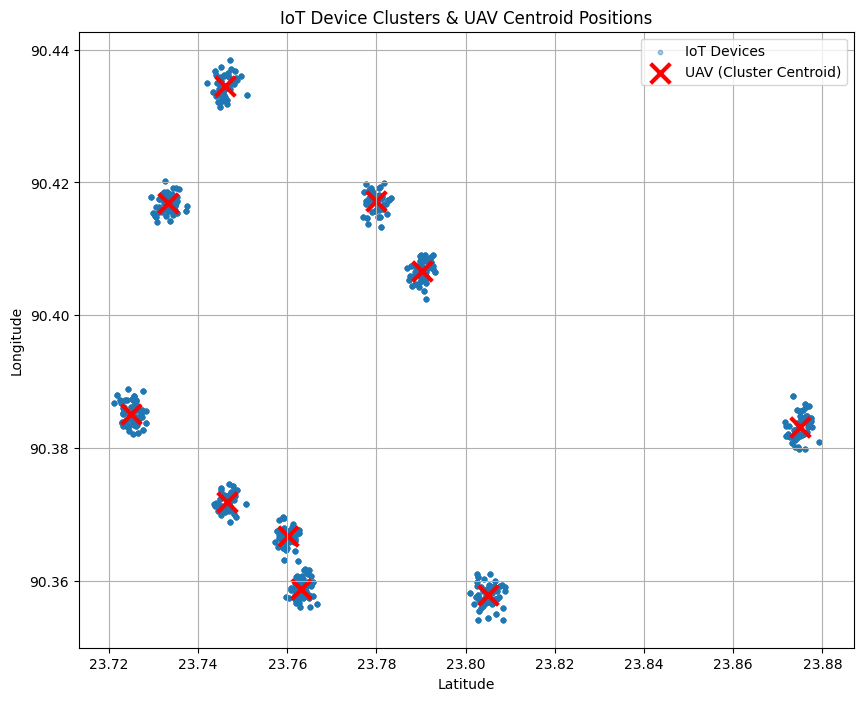

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df = pd.read_csv("GLEMETA_clustered_iot_dataset.csv")

# Compute cluster centroids
centroids = df.groupby('iot_id').first().reset_index()  # ensure unique devices
centroids = centroids[['iot_id', 'Location_Lat', 'Location_Lon']]

# We must merge cluster_id from the original device list
# Extract device → cluster relation from your original objects
device_cluster_map = {dev['iot_id']: dev['cluster_id'] for dev in iot_devices}
centroids['cluster_id'] = centroids['iot_id'].map(device_cluster_map)

# Now compute centroid per cluster
cluster_centroid = centroids.groupby('cluster_id')[['Location_Lat', 'Location_Lon']].mean().reset_index()

print("Cluster Centroids (UAV Positions):")
print(cluster_centroid)

# Plot IoT devices
plt.figure(figsize=(10, 8))
plt.scatter(df["Location_Lat"], df["Location_Lon"], s=10, alpha=0.4, label="IoT Devices")

# Plot UAV (centroids)
plt.scatter(
    cluster_centroid["Location_Lat"],
    cluster_centroid["Location_Lon"],
    marker='x',
    s=200,
    linewidths=3,
    color='red',
    label="UAV (Cluster Centroid)"
)

# Labels
plt.title("IoT Device Clusters & UAV Centroid Positions")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.grid(True)
plt.show()


3D Cluster Analysis

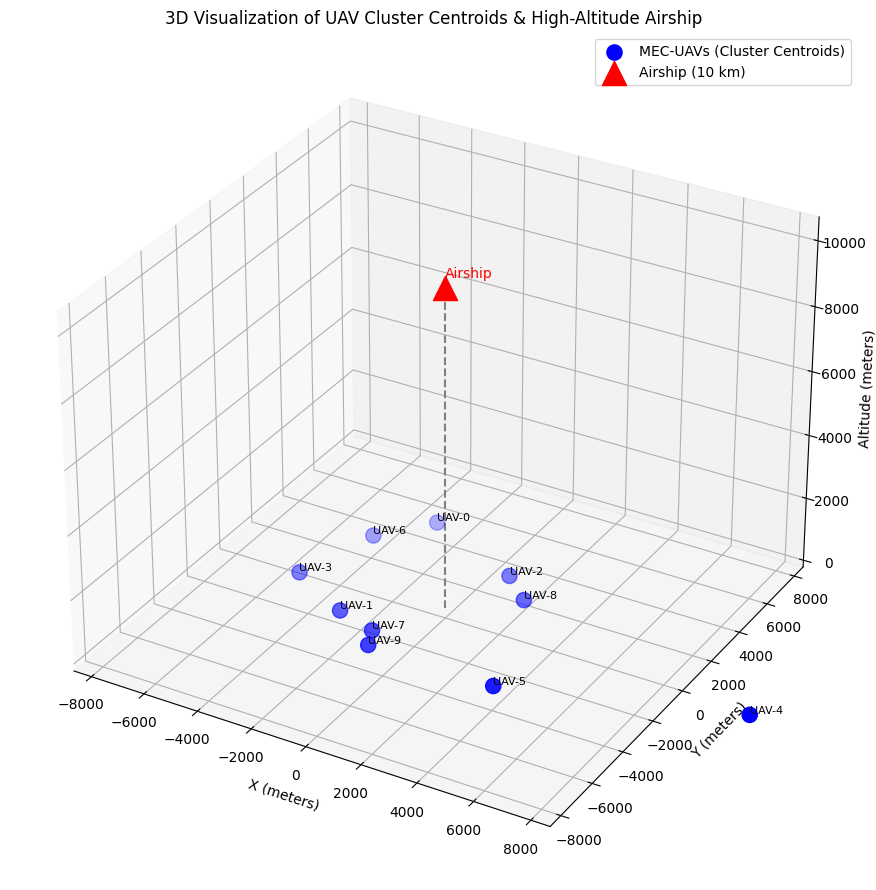

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------
# LOAD DATASET
# -------------------------------------------------
df = pd.read_csv("GLEMETA_clustered_iot_dataset.csv")

# -------------------------------------------------
# COMPUTE UAV LOCATIONS = CLUSTER CENTROIDS
# -------------------------------------------------
# Get unique IoT devices with their lat/lon
centroids = df.groupby('iot_id').first().reset_index()
centroids = centroids[['iot_id', 'Location_Lat', 'Location_Lon']]

# Map cluster IDs (you MUST supply iot_devices: same object you used during dataset generation)
device_cluster_map = {dev['iot_id']: dev['cluster_id'] for dev in iot_devices}
centroids['cluster_id'] = centroids['iot_id'].map(device_cluster_map)

# Compute per-cluster centroid
uav_locations = centroids.groupby('cluster_id')[['Location_Lat', 'Location_Lon']].mean().reset_index()

# Rename for clarity
uav_locations.rename(columns={
    'Location_Lat': 'mec_uav_lat',
    'Location_Lon': 'mec_uav_lon'
}, inplace=True)

# Add altitude
uav_locations['Altitude_m'] = 100

# -------------------------------------------------
# CONVERT LAT/LON TO CARTESIAN METERS
# -------------------------------------------------
LAT_TO_M = 111000
mid_lat = uav_locations['mec_uav_lat'].mean()
LON_TO_M = 111000 * np.cos(np.radians(mid_lat))

uav_locations['x_m'] = (uav_locations['mec_uav_lat'] -
                        uav_locations['mec_uav_lat'].mean()) * LAT_TO_M

uav_locations['y_m'] = (uav_locations['mec_uav_lon'] -
                        uav_locations['mec_uav_lon'].mean()) * LON_TO_M

uav_locations['z_m'] = uav_locations['Altitude_m']

# -------------------------------------------------
# COMPUTE AIRSHIP POSITION
# -------------------------------------------------
airship_x = uav_locations['x_m'].mean()
airship_y = uav_locations['y_m'].mean()
airship_z = 10000  # 10 km

# -------------------------------------------------
# CREATE 3D PLOT
# -------------------------------------------------
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot UAVs
ax.scatter(
    uav_locations['x_m'], uav_locations['y_m'], uav_locations['z_m'],
    c='blue', s=120, marker='o', label='MEC-UAVs (Cluster Centroids)'
)

# Annotate UAV IDs (cluster IDs)
for i, row in uav_locations.iterrows():
    ax.text(
        row['x_m'], row['y_m'], row['z_m'] + 40,
        f"UAV-{int(row['cluster_id'])}",
        fontsize=8, color='black'
    )

# Plot Airship
ax.scatter(
    [airship_x], [airship_y], [airship_z],
    c='red', s=300, marker='^', label='Airship (10 km)'
)
ax.text(airship_x, airship_y, airship_z + 300,
        'Airship', fontsize=10, color='red')

# Draw vertical dashed link between UAV field and Airship
ax.plot(
    [airship_x, airship_x],
    [airship_y, airship_y],
    [100, airship_z],
    linestyle='--', color='gray'
)

# -------------------------------------------------
# LABELS & STYLE
# -------------------------------------------------
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.set_zlabel('Altitude (meters)')
ax.set_title('3D Visualization of UAV Cluster Centroids & High-Altitude Airship')

ax.legend()
plt.tight_layout()

# Scale all axes equally
max_range = np.array([
    uav_locations['x_m'].max() - uav_locations['x_m'].min(),
    uav_locations['y_m'].max() - uav_locations['y_m'].min(),
    airship_z
]).max() / 2

ax.set_xlim(airship_x - max_range, airship_x + max_range)
ax.set_ylim(airship_y - max_range, airship_y + max_range)
ax.set_zlim(0, airship_z + 500)

plt.show()


**Data Set Validation - Statistical Distribution Validation (Task Sizes, Deadlines, Rates, etc.)**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


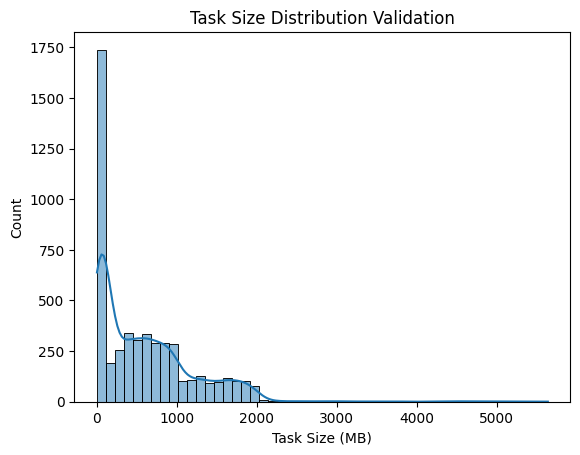

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


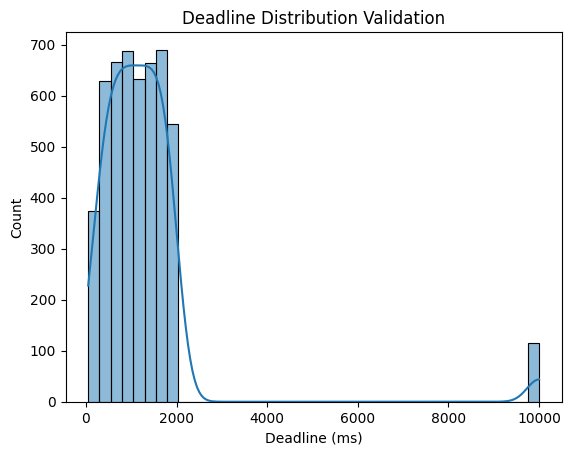

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


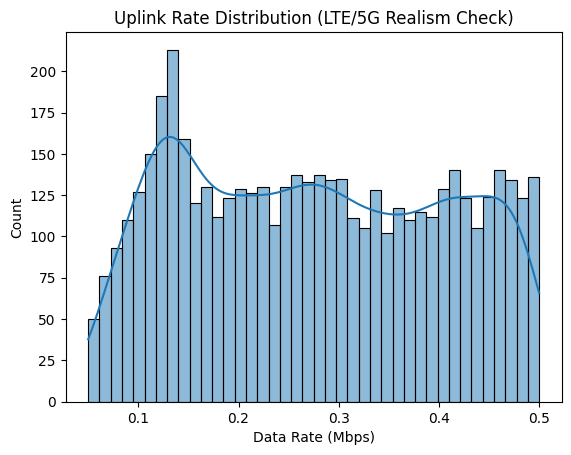

       task_size_MB  delay_deadline_ms  uplink_data_rate_Mbps
count   5000.000000         5000.00000            5000.000000
mean     596.197189         1287.15520               0.275866
std      625.904529         1444.12831               0.127722
min        0.101000           50.00000               0.050066
25%       72.692500          635.75000               0.159320
50%      445.075000         1101.00000               0.271703
75%      905.775000         1579.00000               0.389156
max     5638.020000        10000.00000               0.499854


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution check for task sizes
sns.histplot(iot_df['task_size_MB'], bins=50, kde=True)
plt.title("Task Size Distribution Validation")
plt.xlabel("Task Size (MB)")
plt.show()

# 2. Deadline distribution check
sns.histplot(iot_df['delay_deadline_ms'], bins=40, kde=True)
plt.title("Deadline Distribution Validation")
plt.xlabel("Deadline (ms)")
plt.show()

# 3. Uplink data rate distribution
sns.histplot(iot_df['uplink_data_rate_Mbps'], bins=40, kde=True)
plt.title("Uplink Rate Distribution (LTE/5G Realism Check)")
plt.xlabel("Data Rate (Mbps)")
plt.show()

# Print summary statistics
print(iot_df[['task_size_MB','delay_deadline_ms','uplink_data_rate_Mbps']].describe())


**Data Set Validation - Spatial Clustering Validation (Dhaka city density realism)**

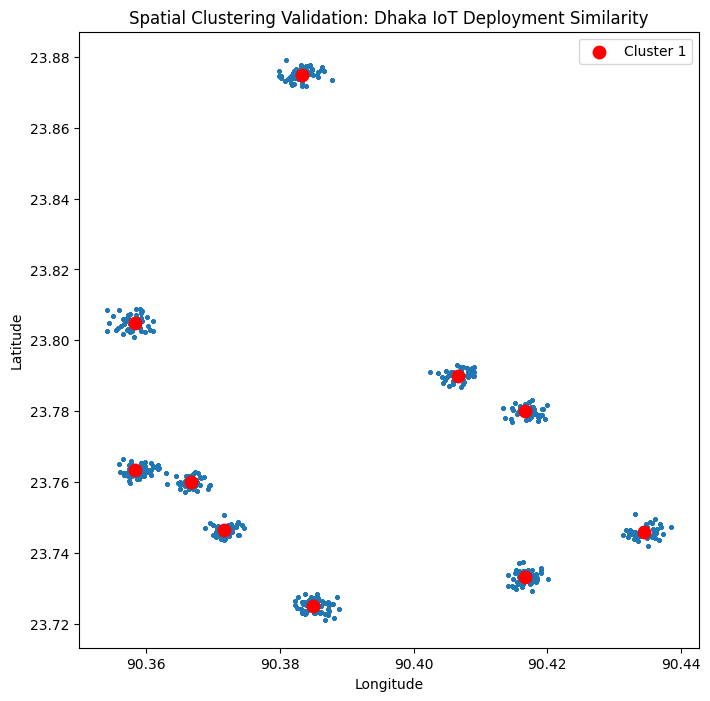

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(iot_df['Location_Lon'], iot_df['Location_Lat'], s=5, alpha=0.5)
for idx, center in enumerate(area_centers):
    plt.scatter(center[1], center[0], c='red', s=80, label=f'Cluster {idx+1}' if idx==0 else "")

plt.title("Spatial Clustering Validation: Dhaka IoT Deployment Similarity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


****Data Set Validation - Anomaly Injection Validation (5% controlled noise)****

In [10]:
anomaly_count = (iot_df['Vibration_G'] > 5).sum()
signal_anomaly_count = (iot_df['Signal_Strength_dBm'] > -50).sum() + (iot_df['Signal_Strength_dBm'] < -120).sum()
deadline_anomaly_count = ((iot_df['delay_deadline_ms'] == 50) | (iot_df['delay_deadline_ms'] == 10000)).sum()

print("Total anomalies (expected ~5% of 5000):", anomaly_count)
print("Signal anomalies:", signal_anomaly_count)
print("Deadline anomalies:", deadline_anomaly_count)
print("Anomaly percentage:", anomaly_count / len(iot_df) * 100)


Total anomalies (expected ~5% of 5000): 298
Signal anomalies: 30
Deadline anomalies: 236
Anomaly percentage: 5.96
